# Matching Sample

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

from pycalf import metrics
from pycalf import propensity

In [3]:
# Download from https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv
df = pd.read_csv('sample/q_data_x.csv')

In [4]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


In [5]:
# Define variables required for inference.
covariate_cols = [
    'TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc', 'pmoney',
    'area_kanto', 'area_tokai', 'area_keihanshin', 'job_dummy1', 'job_dummy2',
    'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6', 'job_dummy7',
    'fam_str_dummy1', 'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'
]
outcome_cols = ['gamecount', 'gamedummy', 'gamesecond']
treatment_col = 'cm_dummy'

# Set Values from dataframe.
X = df[covariate_cols].to_numpy()
y = df[outcome_cols].to_numpy()
treatment = df[treatment_col].astype(bool).to_numpy()

# Define IPW Class.
learner = Pipeline([
    ('sclaer', preprocessing.MinMaxScaler()), 
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
])
model = propensity.Matching(learner, min_match_dist=1e-2)

# Fit model.
model.fit(X, treatment, y)

### 効果量d

In [6]:
ate_weight = model.get_weight(treatment, mode='ate')

es = metrics.EffectSize()
es.fit(df[covariate_cols], treatment, weight=ate_weight)
es.transform()

(array(['TVwatch_day', 'age', 'sex', 'marry_dummy', 'child_dummy', 'inc',
        'pmoney', 'area_kanto', 'area_tokai', 'area_keihanshin',
        'job_dummy1', 'job_dummy2', 'job_dummy3', 'job_dummy4',
        'job_dummy5', 'job_dummy6', 'job_dummy7', 'fam_str_dummy1',
        'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4'], dtype=object),
 array([0.09443502, 0.01895025, 0.03222931, 0.06635312, 0.07227191,
        0.06334289, 0.05588798, 0.10188619, 0.09930529, 0.01867008,
        0.00957561, 0.15925743, 0.09295264, 0.03793126, 0.08693683,
        0.13956678, 0.00440277, 0.03485716, 0.00191983, 0.01388128,
        0.04832365]))

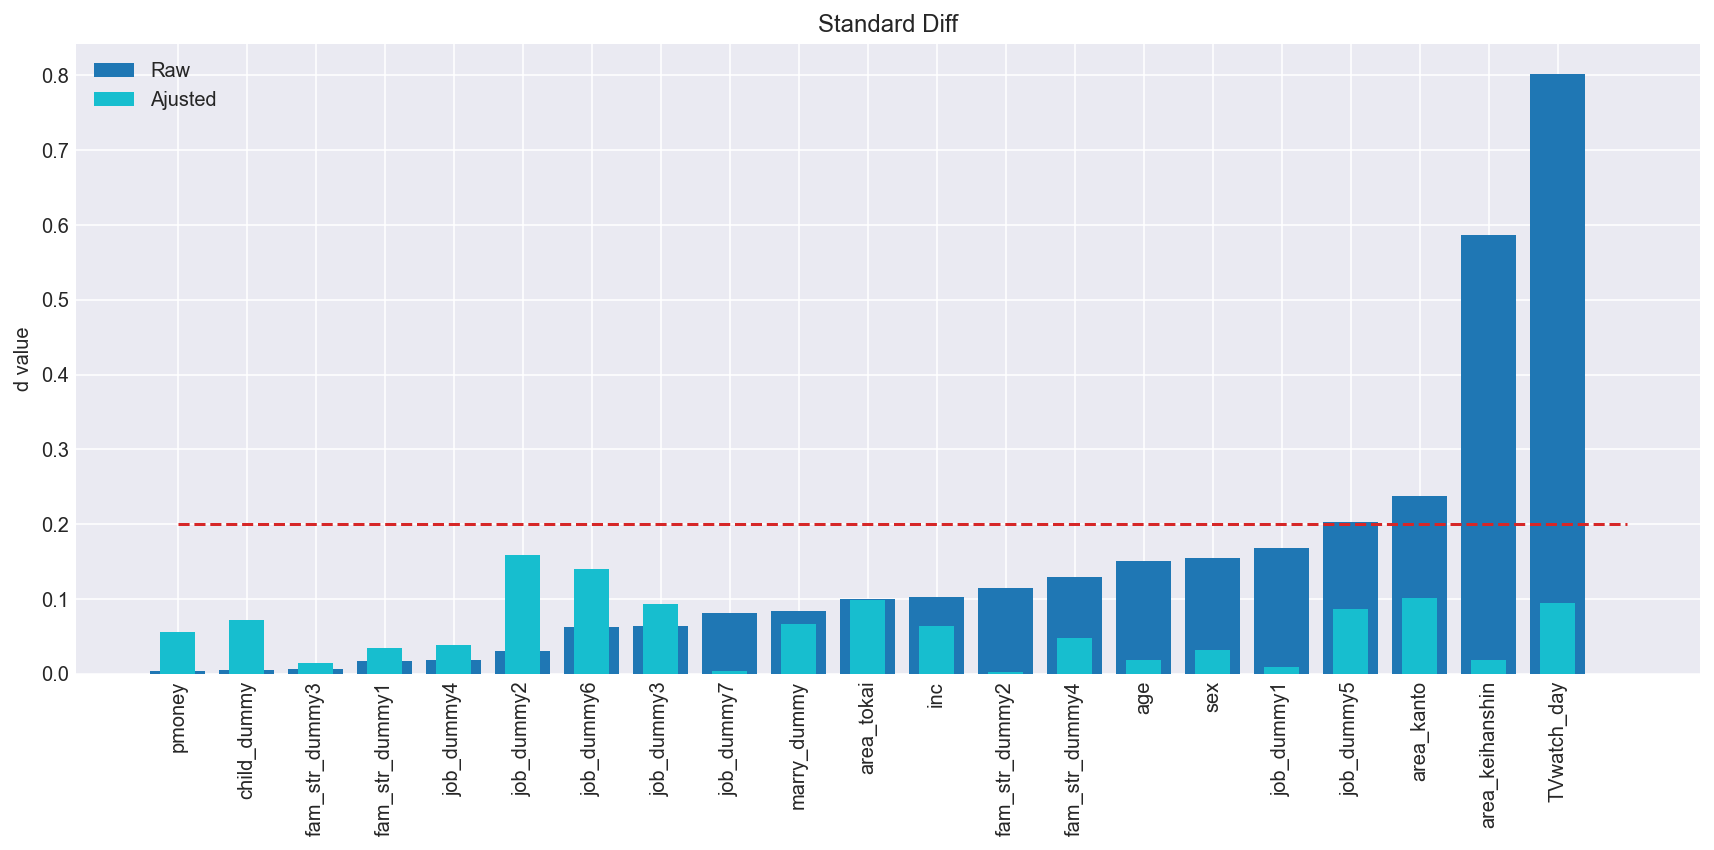

In [7]:
metrics.plot_effect_size(df[covariate_cols], treatment, weight=ate_weight, ascending=True)

### AUC と 傾向スコアの分布の可視化

ここでは、AUC と 介入有無別の傾向スコアの分布を可視化する。

AUC は、0.7 以上であることが好ましいとされる。
参考：https://www.jstage.jst.go.jp/article/tenrikiyo/19/2/19_19-008/_pdf

介入有無別の傾向スコアの分布は、ある程度重なりが有りながら介入有無別の分布が別れているので傾向スコアによる調整が行えるように見える。

F1 Score:  0.6839307927174036


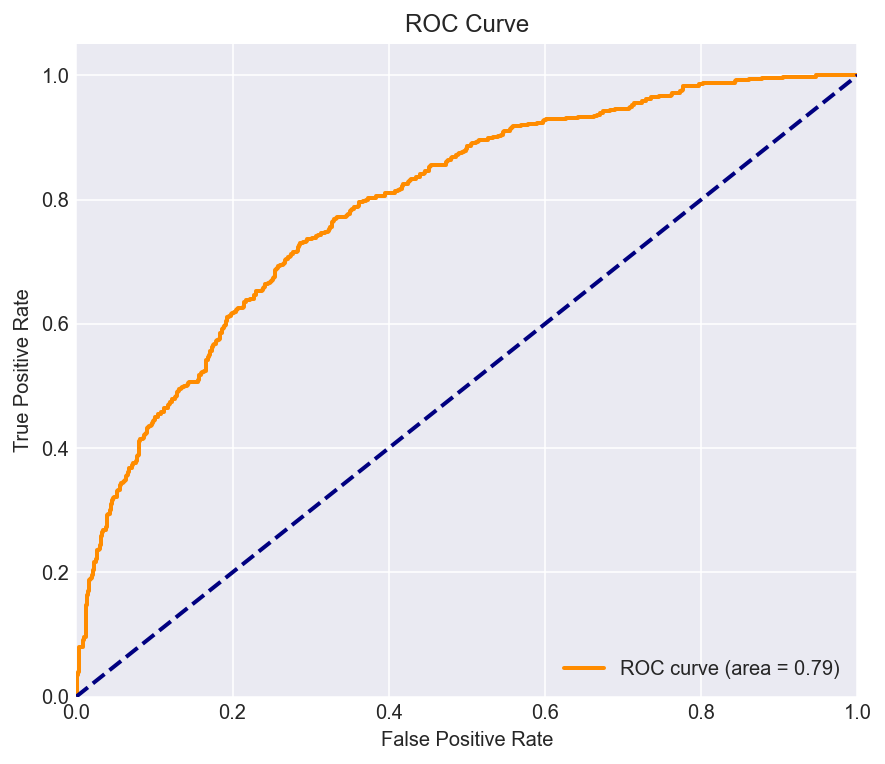

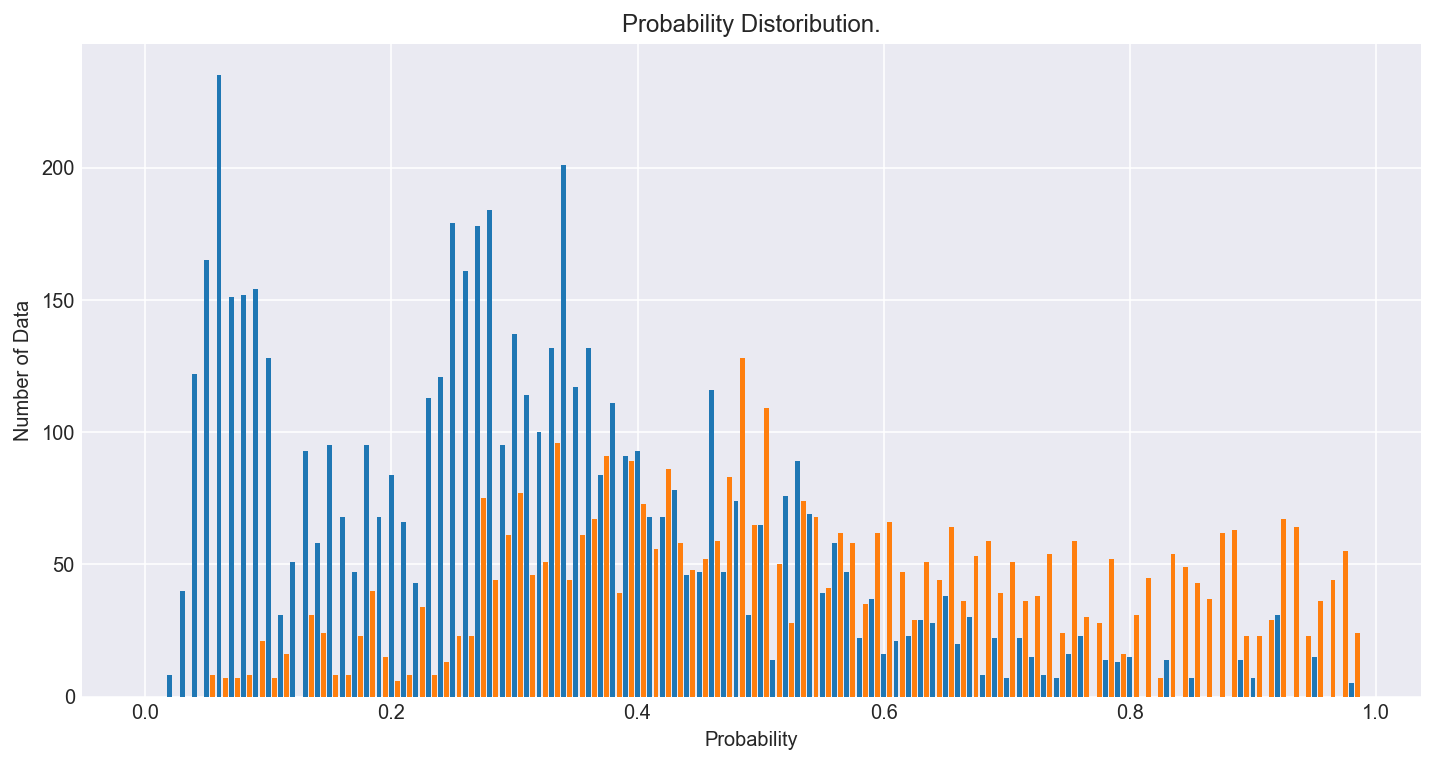

In [8]:
print('F1 Score: ', metrics.f1_score(treatment, model.get_score(), threshold='auto'))
metrics.plot_roc_curve(treatment, model.get_score())
metrics.plot_probability_distribution(treatment, model.get_score())

### 平均処置効果（ATE: Average Treated Effect）

IPW による調整後の介入効果

In [9]:
outcome = model.estimate_effect(treatment, y, mode='ate')
pd.DataFrame(outcome, index=['Z0', 'Z1', 'ATE'], columns=outcome_cols).T

,Z0,Z1,ATE
gamecount,7.234809,8.563948,1.329138
gamedummy,0.062307,0.075290,0.012983
gamesecond,2309.220391,2478.065878,168.845487


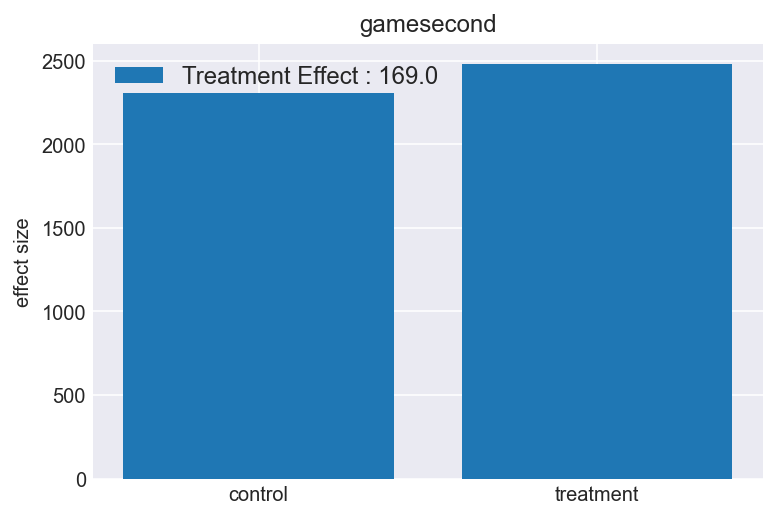

In [10]:
outcome_name = 'gamesecond'
z0, z1, treat_effect = model.estimate_effect(treatment, y[:, 2].reshape(-1, 1), mode='ate')
metrics.plot_treatment_effect(outcome_name, z0[0], z1[0], treat_effect[0].round())

### 属性変数を用いた介入効果の推定

,Z0_effect,Z0_tvalue,Z1_effect,Z1_tvalue,Lift
area_kanto,3680.6,8.35**,-102.3,-0.16,-3782.9
F1,2118.8,4.77**,-1430.4,-2.05**,-3549.2
M1,4030.7,7.63**,906.9,1.25,-3123.8
F2,2568.7,5.82**,124.0,0.22,-2444.7
area_tokai,1130.7,2.3**,-920.5,-1.21,-2051.2
child_dummy,773.8,2.04**,-274.2,-0.53,-1048.0
M3,-1447.2,-3.48**,-1071.9,-1.84,375.3
area_keihan,892.0,2.98**,2259.8,5.92**,1367.8
F3,-1382.1,-1.71,551.8,0.57,1933.9
T,-164.8,-0.09,2143.3,1.1,2308.1


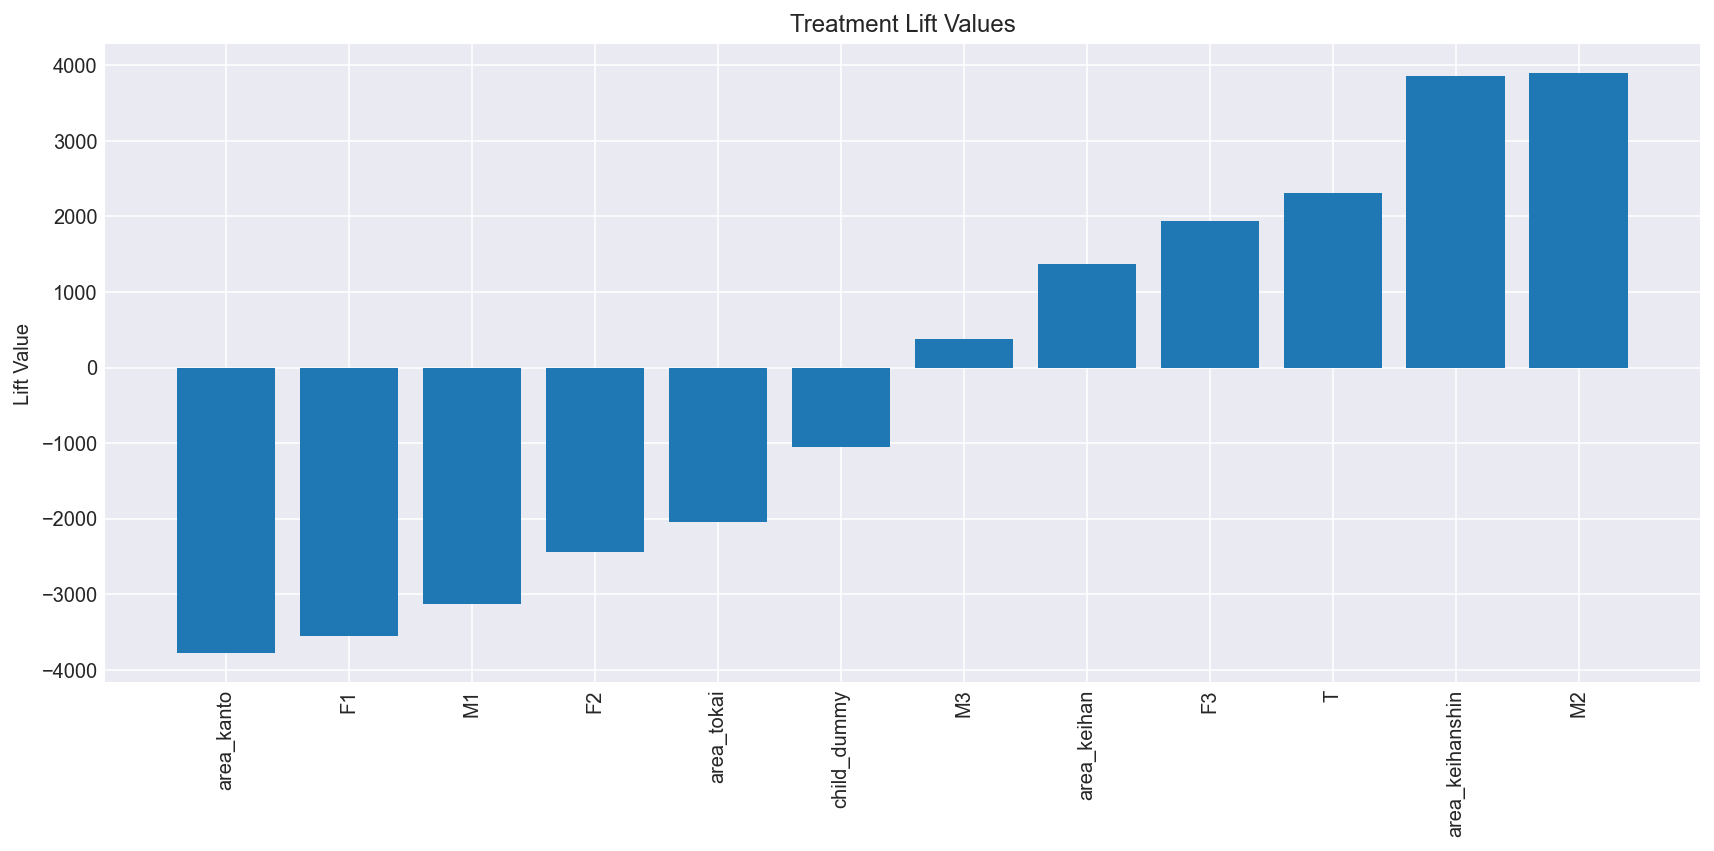

In [11]:
# Attribute Effect
treatment_col = 'cm_dummy'
y = 'gamesecond'
features = [
    'child_dummy', 'area_kanto', 'area_keihan', 'area_tokai', 'area_keihanshin',
    'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3'
]

attr_effect = metrics.AttributeEffect()
attr_effect.fit(df[features], treatment, df[y], weight=model.get_weight(treatment, mode='ate'))
result = attr_effect.transform()

display(result)
attr_effect.plot_lift_values()